In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
rng = np.random.default_rng(20251204)

# Linear

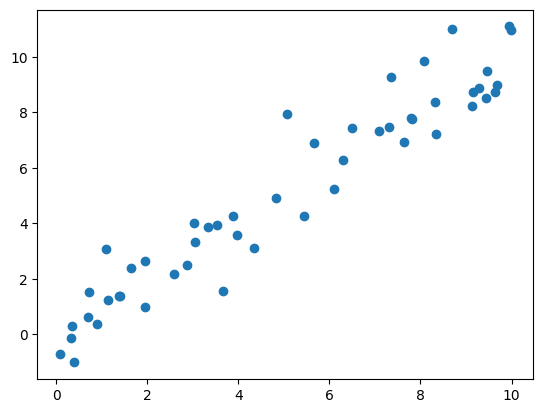

In [3]:
x = rng.uniform(0, 10, 50)
y = x + rng.normal(0, 1, len(x))
plt.scatter(x, y)

## Linear com heterocedasticidade

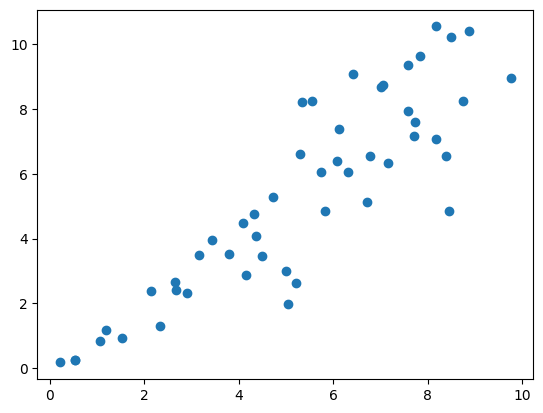

In [4]:
x = rng.uniform(0, 10, 50)
y = [i + rng.normal(0, i/4) for i in x]
plt.scatter(x, y)

# Quadrático

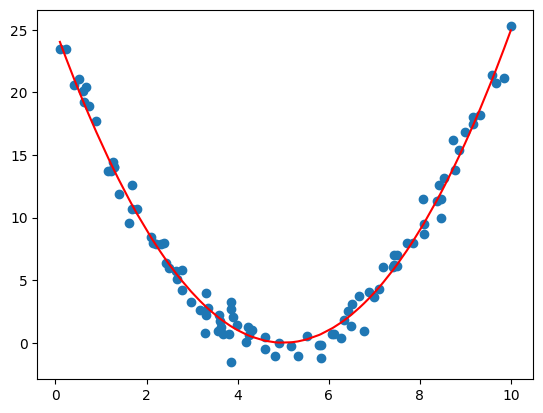

In [5]:
n = 100

x = rng.uniform(0, 10, n)
y_denoised = [i**2 - 10*i + 25 for i in x]
y = [i + rng.normal(0, 1) for i in y_denoised]

sns.lineplot(x=x, y=y_denoised, color='red')
plt.scatter(x, y)

## Com heterocedasticidade

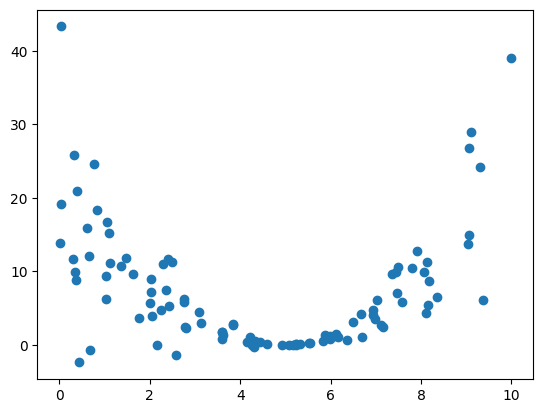

In [13]:
n = 100

x = rng.uniform(0, 10, n)
y_denoised = [i**2 - 10*i + 25 for i in x]
y = [i + rng.normal(0, i/2) for i in y_denoised]

plt.scatter(x, y)

## Com probabilidade de aceitação

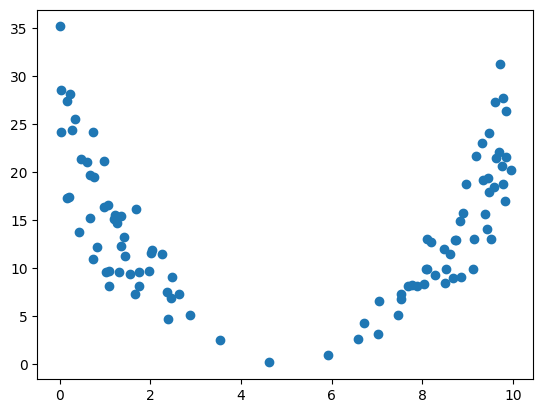

In [12]:
def sample_u_power(n, k=5, rng=None):
    """
    Sample n values on (0,10) from f(x) ∝ |x-5|^k using rejection sampling.
    k controls how deep the middle valley is (higher k -> lower center prob).
    """
    if rng is None:
        rng = np.random.default_rng()
    samples = []
    # envelope max f occurs at edges: |x-5| = 5, so f_max = 5**k (we use ratio f(x)/f_max)
    while len(samples) < n:
        x = rng.random() * 10.0            # candidate from Uniform(0,10)
        u = rng.random()
        accept_prob = (abs(x - 5.0) / 5.0) ** k
        if u < accept_prob:
            samples.append(x)
    return np.array(samples)

n = 100

x = sample_u_power(n, k=2, rng=rng)
y_denoised = [i**2 - 10*i + 25 for i in x]
y = [i + rng.normal(0, i/4) for i in y_denoised]

plt.scatter(x, y)

# Paper Luben

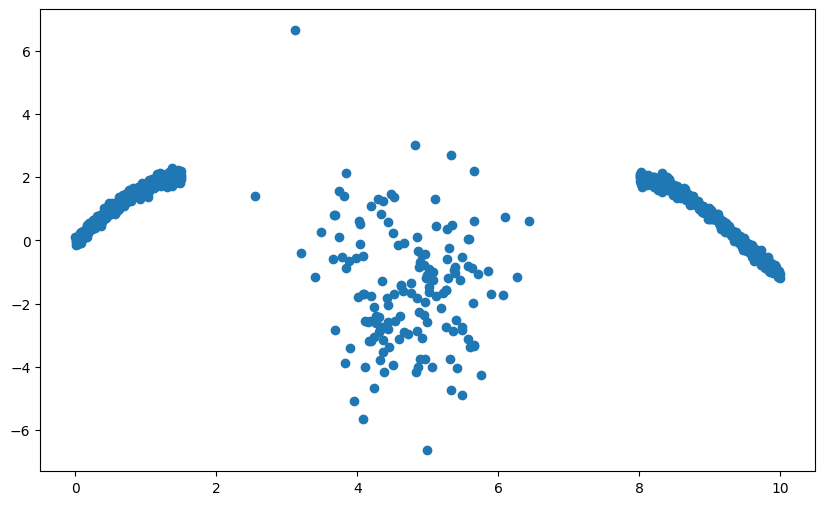

In [11]:
from sklearn.neighbors import KNeighborsRegressor

def generate_data(n, rng):
    # Proportional number of points for dense and sparse regions
    num_dense = round(0.425 * n)  # half of the data points go to dense regions
    num_middle = round(
        0.15 * n
    )  # a small fraction of data points for the middle region

    # Generate x values for dense and sparse regions
    x_dense1 = rng.uniform(0, 1.5, num_dense)
    x_dense2 = rng.uniform(8, 10, num_dense)
    # using beta
    x_middle = (rng.beta(8, 8, num_middle) * (8 - 1.5)) + 1.5
    x_sparse = np.concatenate([x_dense1, x_dense2, x_middle])

    # True function to generate y based on x
    def true_function(x):
        y = 2 * np.sin(x) + rng.normal(0, 0.1, len(x))
        mask = (2 < x) & (x < 7.5)
        y[mask] += rng.normal(0, 2, np.sum(mask))
        return y

    # Generate y values
    y = true_function(x_sparse)

    # Return as a data frame
    return pd.DataFrame({"x": x_sparse, "y": y})

rng = np.random.default_rng(45)
alpha = 0.1
# considering 500 samples first
# Simulating samples
data_train = generate_data(1000, rng)
data_calibration = generate_data(1000, rng)
data_test = generate_data(1000, rng)

X_test = data_test["x"].to_numpy().reshape(-1, 1)
y_test = data_test["y"].to_numpy()

X_calib = data_calibration["x"].to_numpy().reshape(-1, 1)
y_calib = data_calibration["y"].to_numpy()

# gridding
x_grid = np.linspace(data_train["x"].min(), data_train["x"].max(), 300).reshape(-1, 1)

# fitting base model
X_train = data_train["x"].to_numpy().reshape(-1, 1)
y_train = data_train["y"].to_numpy()

model = KNeighborsRegressor(n_neighbors=10)
model.fit(X_train, y_train)

n_sample = 500

# Plotting the fitted model
plt.figure(figsize=(10, 6))
plt.scatter(data_train["x"], data_train["y"])